In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer
import utils

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
from utils import read_json

config = read_json("experiments/ppc_flowers_config.json")
config = ConfigParser(config)

In [7]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
optimizer = config.init_obj('optimizer', pyro.optim)

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=None)

trainer._resume_checkpoint("saved/models/FlowersDiffusion_Ppc/0502_011314/checkpoint-epoch180.pth")

DiffusionPpc(
  (diffusion): DiffusionStep(
    (unet): ScoreNetwork0(
      (_convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LogSigmoid()
        )
        (1): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): LogSigmoid()
        )
        (2): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): LogSigmoid()
        )
        (3): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): LogSigmoid()
        )
        (4): Sequential(
          (0): MaxPool2d(ker

In [8]:
trainer.model.eval()
trainer.cpu()
trainer.valid_particles.cpu()

ParticleDict(
    (X__50): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__49): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__48): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__47): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__46): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__45): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__44): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__43): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__42): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__41): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__40): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__39): Parameter containing: [torch.FloatTensor of size 5x102x3x64x64]
    (X__38): Parameter containing: [torch.FloatTensor of size 

In [9]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [35]:
xs, _, indices = list(trainer.valid_data_loader)[0]
trainer._load_particles(indices, False)
with pyro.plate_stack("forward", (trainer.num_particles, len(xs))):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    x_hats = model().mean(dim=0)

In [36]:
import matplotlib.pyplot as plt

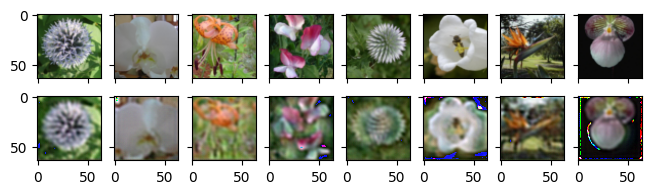

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    orgs = data_loader.reverse_transform(xs[i].squeeze().detach())
    estimates = data_loader.reverse_transform(x_hats[i].squeeze().detach())
    axes[0, i].imshow(orgs)
    axes[1, i].imshow(estimates)

fig.savefig("ppc_flowers_recons.pdf", bbox_inches="tight")
plt.show()

In [13]:
del xs
del x_hats

In [39]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.unclamp(site)

In [40]:
with pyro.plate_stack("forward", (trainer.num_particles, 8)):
    x_hats = trainer.model()

/workspace/shai_hulud/ppc_experiments/data_loader/data_loaders.py:120: RuntimeWarning: invalid value encountered in cast
  transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),


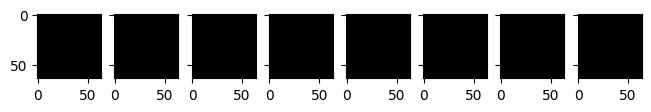

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    estimates = data_loader.reverse_transform(x_hats[i].squeeze().detach())
    axes[i].imshow(estimates)

fig.savefig("ppc_flowers_samples.pdf", bbox_inches="tight")
plt.show()

In [17]:
del x_hats

In [18]:
SEEDS = [123, 456, 789, 101112, 131415]

In [19]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [20]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for b, (xs, target, indices) in enumerate(trainer.valid_data_loader):
        trainer._load_particles(indices, False)
    
        with pyro.plate_stack("forward", (trainer.num_particles, len(xs))):
            model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
            trace = pyro.poutine.trace(model).get_trace()
            x_hats = trace.nodes['X__0']['value'].mean(dim=0)
        LOG_LIKELIHOODS[s] += trace.nodes['X__0']['fn'].log_prob(xs).sum()
        MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean()

        del xs
        del x_hats
        logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))

    LOG_LIKELIHOODS[s] /= len(trainer.valid_data_loader.sampler)
    MEAN_SQUARED_ERROR[s] /= len(trainer.valid_data_loader.sampler)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated

In [21]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-86349672., grad_fn=<MeanBackward0>),
 tensor(6950274.5000, grad_fn=<StdBackward0>))

In [22]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.1128, grad_fn=<MeanBackward0>),
 tensor(0.0091, grad_fn=<StdBackward0>))